In [23]:
#In this modeling project involving optimal US portflio, there are three objectives: 
#Maximization of information ratio
#Minimization of tracking error with the Nasdaq 100

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.ion()  # Turn on interactive mode
from scipy.optimize import minimize

# Input validation for file path
def load_data(file_path):
    try:
        df = pd.read_excel(file_path, index_col='Date', parse_dates=True)
        # Separate NQ100 and investment assets
        nq100 = df['NQ100']
        investment_df = df.drop('NQ100', axis=1)
        return investment_df, nq100
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

# Dividend yields as a dictionary
DIVIDEND_YIELDS = {
    'XLY': 0.0069,
    'VZ': 0.0662,
    'UBER': 0,
    'TSLZ': 0.7567,
    'SQQQ': 0.1188,
    'SEA': 0.0936,
    'SBLK': 0.0915,
    'QYLD': 0.1124,
    'NVDA': 0.0001,
    'HYBL': 0.0819,
    'GOOG': 0.0022,
    'EVAV': 0.0349,
    'DRIV': 0.0173,
    'ARM': 0,
    'AMD': 0
}


In [25]:
def calculate_portfolio_tracking_error(weights, returns, benchmark_returns):
    portfolio_returns = (returns * weights).sum(axis=1)
    return_diff = portfolio_returns - benchmark_returns
    tracking_error = return_diff.std() 
    return tracking_error

def calculate_tracking_error(asset_returns, benchmark_returns):
    return_diff = asset_returns - benchmark_returns
    tracking_error = return_diff.std()
    information_ratio = (asset_returns.mean() - benchmark_returns.mean()) / tracking_error if tracking_error != 0 else 0
    covariance = np.cov(asset_returns, benchmark_returns)[0][1]
    beta = covariance / benchmark_returns.var() if benchmark_returns.var() != 0 else 0
    correlation = np.corrcoef(asset_returns, benchmark_returns)[0][1]
    r_squared = correlation ** 2
    
    return {
        'tracking_error': tracking_error,
        'information_ratio': information_ratio,
        'beta': beta,
        'r_squared': r_squared,
        'correlation': correlation
    }

def calculate_information_ratio(weights, returns, benchmark_returns):
    portfolio_returns = (returns * weights).sum(axis=1)
    return_diff = portfolio_returns - benchmark_returns
    tracking_error = return_diff.std()
    ir = (portfolio_returns.mean() - benchmark_returns.mean()) / tracking_error if tracking_error != 0 else 0
    return ir

In [26]:
def portfolio_objective(weights, returns, benchmark_returns, dividend_yields):
    # Calculate tracking error (minimize)
    tracking_error = calculate_portfolio_tracking_error(weights, returns, benchmark_returns)
    
    # Calculate dividend yield (maximize)
    portfolio_dividend = np.sum(weights * dividend_yields)
    
    # Calculate information ratio (maximize)
    ir = calculate_information_ratio(weights, returns, benchmark_returns)
    
    # Combined objective with equal weights (1.0 for all)
    # Negative signs for dividend and IR because we want to maximize them
    return tracking_error - portfolio_dividend - ir

In [27]:
def optimize_portfolio(returns, benchmark_returns, dividend_yields, min_dividend=0.05, 
                      max_weight=0.30, min_weight=0.02):
    num_assets = len(returns.columns)
    
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # weights sum to 1
        {'type': 'ineq', 'fun': lambda x: np.sum(x * dividend_yields) - min_dividend}  # minimum dividend yield
    ]
    
    # Set default bounds
    bounds = [(min_weight, max_weight) for _ in range(num_assets)]
    
    # Find correct indices based on DataFrame columns
    tslz_index = returns.columns.get_loc('TSLZ')
    sqqq_index = returns.columns.get_loc('SQQQ')
    
    bounds[sqqq_index] = (0.01, 0.03)  # SQQQ: 1-3%
    bounds[tslz_index] = (0.01, 0.05)  # TSLZ: 1-5%
    
    result = minimize(portfolio_objective,
                     x0=np.array([1.0/num_assets] * num_assets),
                     args=(returns, benchmark_returns, dividend_yields),
                     method='SLSQP',
                     bounds=tuple(bounds),
                     constraints=constraints)
    
    if not result.success:
        print(f"Optimization failed: {result.message}")
    
    return result.x


In [28]:
def plot_portfolio_allocation(results_df, investment_amount, portfolio_dividend_yield):
    distinct_colors = [
        'bisque', 'cornsilk', 'sandybrown', 'tan', 'navajowhite',
        'burlywood', 'antiquewhite', 'tan', 'darkgoldenrod', 'goldenrod',
        'khaki', 'palegoldenrod', 'darkkhaki', 'gold', 'wheat'
    ]
    
    sorted_data = results_df.copy()
    sorted_data['Weight_Float'] = sorted_data['Optimal Weight'].str.rstrip('%').astype(float) / 100
    sorted_data = sorted_data.sort_values('Weight_Float', ascending=False)
    
    plt.figure(figsize=(15, 10))
    wedges, texts, autotexts = plt.pie(sorted_data['Weight_Float'], 
                                      labels=sorted_data['Asset'],
                                      autopct='%1.1f%%',
                                      startangle=90,
                                      colors=distinct_colors[:len(sorted_data)],
                                      pctdistance=0.85)
    
    plt.setp(autotexts, size=9, weight="bold")
    plt.setp(texts, size=9)
    
    plt.legend(wedges, sorted_data['Asset'],
              title="Assets",
              loc="center left",
              bbox_to_anchor=(1.2, 0, 0.5, 1))
    
    plt.title(f'Portfolio Allocation\n(Dividend Yield: {portfolio_dividend_yield:.2%})',
              pad=20, size=12, weight='bold')
    
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()


Tracking Metrics vs NQ100:
      Tracking Error  Information Ratio   Beta  R-squared  Correlation
XLY            0.007             -0.012  0.820      0.655        0.809
QYLD           0.007             -0.149  0.478      0.655        0.809
DRIV           0.009             -0.109  0.966      0.575        0.758
HYBL           0.010             -0.114  0.088      0.162        0.403
GOOG           0.014             -0.020  0.923      0.354        0.595
SEA            0.014             -0.064  0.353      0.098        0.313
VZ             0.019             -0.019 -0.091      0.005       -0.070
SBLK           0.019             -0.059  0.434      0.066        0.258
UBER           0.021              0.040  1.019      0.221        0.470
AMD            0.025              0.018  1.856      0.459        0.677
NVDA           0.025              0.155  2.177      0.575        0.758
SQQQ           0.044             -0.117 -2.955      0.993       -0.997
ARM            0.050              0.082  2.545   

C:\Users\user\anaconda3_2\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
C:\Users\user\anaconda3_2\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "



Optimized Portfolio Allocation:
Asset Optimal Weight Dollar Allocation
 NVDA          30.0%         $2,400.00
  XLY          24.9%         $1,989.33
   VZ          11.1%           $886.03
  ARM           8.3%           $663.28
 UBER           4.7%           $373.01
 TSLZ           4.1%           $328.36
 EVAV           2.0%           $160.00
  SEA           2.0%           $160.00
  AMD           2.0%           $160.00
 HYBL           2.0%           $160.00
 GOOG           2.0%           $160.00
 QYLD           2.0%           $160.00
 SBLK           2.0%           $160.00
 DRIV           2.0%           $160.00
 SQQQ           1.0%            $80.00

Portfolio Dividend Yield: 5.00%
Portfolio Information Ratio: 0.12

Tracking Error Metrics vs NQ100:
Tracking Error: 0.83%
Information Ratio: 0.12
Beta: 1.08
R-squared: 0.69


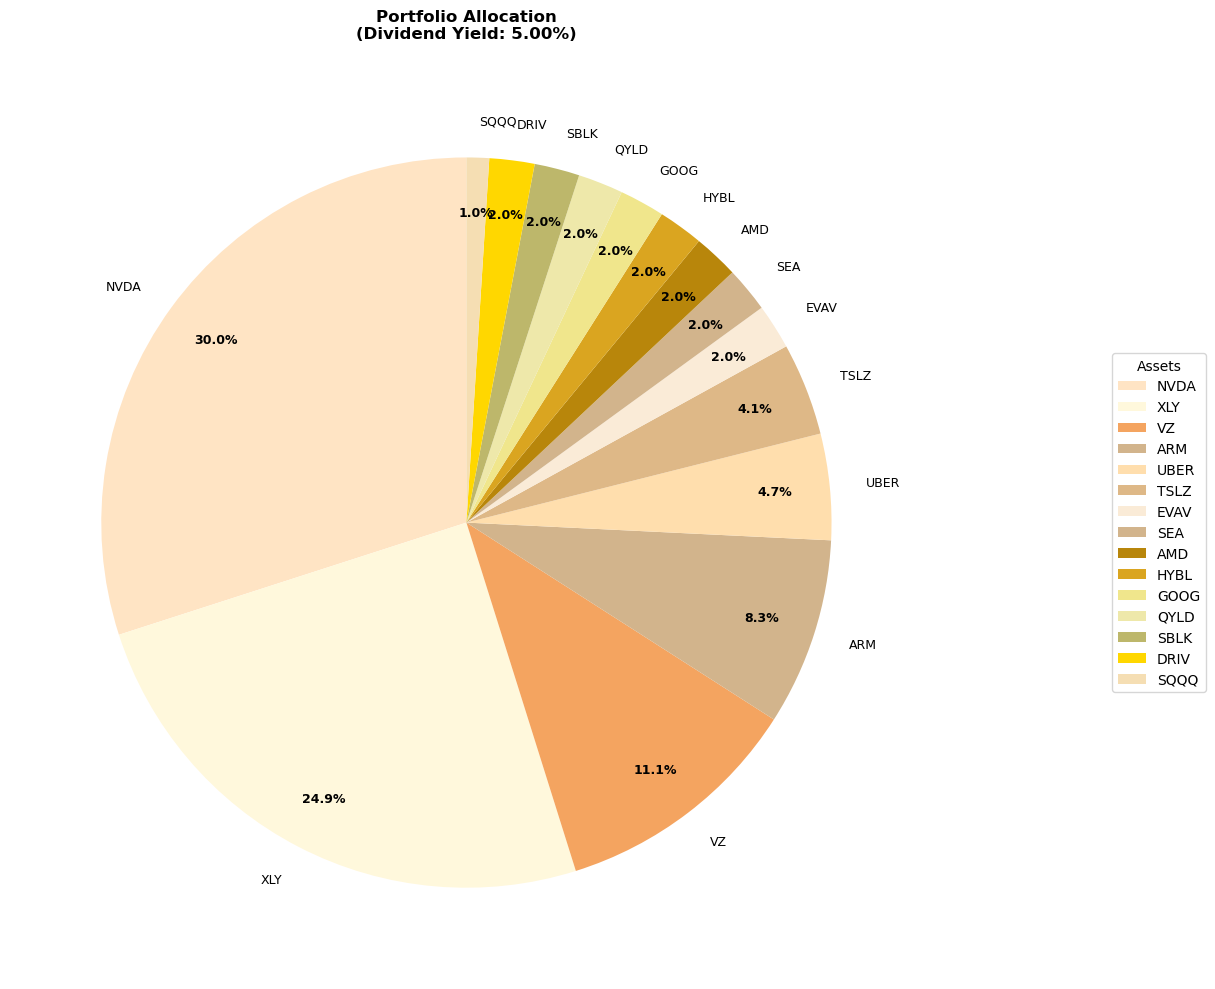

In [30]:
def main():
    file_path = r'D:\Derivatives Trading\US Equity Databank.xlsx'
    investment_df, nq100 = load_data(file_path)
    if investment_df is None:
        return
    
    returns = investment_df.pct_change().dropna()
    nq100_returns = nq100.pct_change().dropna()
    
    tracking_metrics = {}
    for column in returns.columns:
        metrics = calculate_tracking_error(returns[column], nq100_returns)
        tracking_metrics[column] = metrics
    
    tracking_metrics_df = pd.DataFrame({
        'Tracking Error': [m['tracking_error'] for m in tracking_metrics.values()],
        'Information Ratio': [m['information_ratio'] for m in tracking_metrics.values()],
        'Beta': [m['beta'] for m in tracking_metrics.values()],
        'R-squared': [m['r_squared'] for m in tracking_metrics.values()],
        'Correlation': [m['correlation'] for m in tracking_metrics.values()]
    }, index=returns.columns)
    
    tracking_metrics_df = tracking_metrics_df.sort_values('Tracking Error', ascending=True)
    print("\nTracking Metrics vs NQ100:")
    pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
    print(tracking_metrics_df)
    
    dividend_yields = np.array([DIVIDEND_YIELDS[asset] for asset in returns.columns])
    investment_amount = 8000
    
    print("\n=== Portfolio Optimization (Equal weights for Tracking Error, Dividend, and Information Ratio) ===")
    
    optimal_weights = optimize_portfolio(returns, nq100_returns, dividend_yields)
    portfolio_dividend_yield = np.sum(optimal_weights * dividend_yields)
    
    portfolio_returns = (returns * optimal_weights).sum(axis=1)
    tracking_metrics = calculate_tracking_error(portfolio_returns, nq100_returns)
    
    # Calculate portfolio information ratio
    portfolio_ir = calculate_information_ratio(optimal_weights, returns, nq100_returns)
    
    results_df = pd.DataFrame({
        'Asset': returns.columns,
        'Optimal Weight': optimal_weights,
        'Dollar Allocation': optimal_weights * investment_amount
    }).sort_values('Optimal Weight', ascending=False)
    
    results_df['Optimal Weight'] = results_df['Optimal Weight'].map('{:.1%}'.format)
    results_df['Dollar Allocation'] = results_df['Dollar Allocation'].map('${:,.2f}'.format)
    
    print("\nOptimized Portfolio Allocation:")
    print(results_df.to_string(index=False))
    print(f"\nPortfolio Dividend Yield: {portfolio_dividend_yield:.2%}")
    print(f"Portfolio Information Ratio: {portfolio_ir:.2f}")
    
    print("\nTracking Error Metrics vs NQ100:")
    print(f"Tracking Error: {tracking_metrics['tracking_error']:.2%}")
    print(f"Information Ratio: {tracking_metrics['information_ratio']:.2f}")
    print(f"Beta: {tracking_metrics['beta']:.2f}")
    print(f"R-squared: {tracking_metrics['r_squared']:.2f}")
    
    plot_portfolio_allocation(results_df, investment_amount, portfolio_dividend_yield)

if __name__ == "__main__":
    main()